In [0]:
import scipy.stats as sps
import numpy as np

В данной части мы генерируем синтетические данные, которые в дальнейшем будут использованы для проверки работы алгоритма.

In [0]:
# количество признаков
n = 30
# размер выборки
m = 100
def data_generator(n, m, cov=0.2):
  # cov - коэффициент, задающий ковариацию между значениями
  # исходная мартица ковариации (может не быть положительно определенной) 
  pred_C = (1 - cov) * np.eye(n) + cov * np.ones((n, n))
  # вектор средних значений
  mean = np.zeros((n, ))
  # новая матрица ковариации, близкая к исходной, но положительно определенная
  # и с более разнообразными собственными значениями
  C = np.cov(sps.multivariate_normal(mean, pred_C).rvs(size=m).T)
  # поделим строки и стобцы на корень из диагонали чтобы генерируемые Х имели
  # единичную дисперсию
  diag_sqrt = np.sqrt(np.diag(C))
  C = C / diag_sqrt
  C = C.T / diag_sqrt
  # генерируем выборку - она имеет нулевое матожидание и (почти) единичную 
  # дисперсию в каждом столбце
  X = sps.multivariate_normal(mean, C).rvs(size=m)
  # генерируем коэффициенты и делим их на соответствующее число, чтобы в итоге
  # дисперсия Z была равна 1
  a = sps.uniform(loc=0, scale=1).rvs(n)
  a /= (a.dot(a) * (1 - cov) + cov * (a.sum())**2)
  # генерируем предсказываемую переменную так, чтобы ее дисперсия была равна 1
  # для этого делим на соответствующий коэффициент 
  Z = X.dot(a) + sps.norm(loc=0, scale=0.1).rvs(size=m)
  
  return X, Z

Далее реализуем метод ForwardRegression и OMP


In [0]:
def Greedy(X, y, model, k, score):
  model.fit(X, y)
  S = []
  n = X.shape[1]
  used = np.zeros((n, n))
  scores = []
  while len(S) < k:
    max_score = 0
    max_index = 0
    for i in range(n):
      if i not in S:
        used[i, i] = 1
        y_pred = model.predict(X.dot(used))
        used[i, i] = 0
        new_score = score(y, y_pred)
        if new_score > max_score:
          max_index = i
          max_score = new_score
    S.append(max_index)
    used[max_index, max_index] = 1
    scores.append(max_score)
  return S, used, np.array(scores)

In [0]:
def ForwardRegression(X, y, model, k):
  return Greedy(X, y, model, k, r2_score)

In [0]:
def OMP(X, y, model, k, cov_score):
  return Greedy(X, y, model, k, cov_score)

In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import trange


times = 30
n = 30
m = 100
k_max = n // 2
results = np.zeros((k_max, ))
regression = LinearRegression()
for i in trange(times):
  x, z = data_generator(n, m)
  _, _, scores = ForwardRegression(x, z, regression, k_max)
  results += scores
results /= times

100%|██████████| 30/30 [00:04<00:00,  6.36it/s]


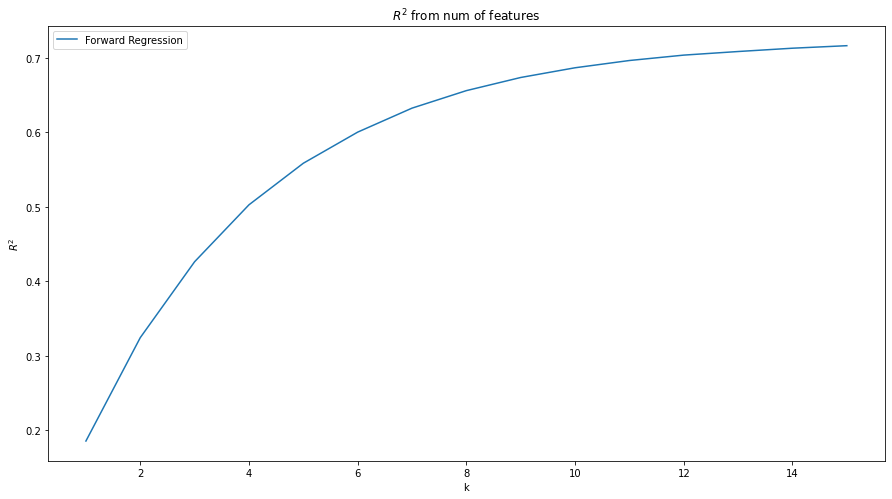

In [121]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 8))

plt.plot(range(1, k_max + 1), results, label='Forward Regression')
plt.xlabel('k')
plt.ylabel(r'$R^2$')
plt.title(r"$R^2$ from num of features")
plt.legend()
plt.show()